<font size ="4">**Importing all the libraries**</font>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

#additioinally imported
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


#nltk.download('all')

[nltk_data] Downloading package punkt to /home/u194134/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194134/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u194134/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


------------------------------------------------------------

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [2]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip /content/News-_dataset.zip -d data/

-------------------------------------------------------------------

<font size="4">**Read the data csv file**</font>

In [3]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_data = pd.read_csv('data/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [5]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [6]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

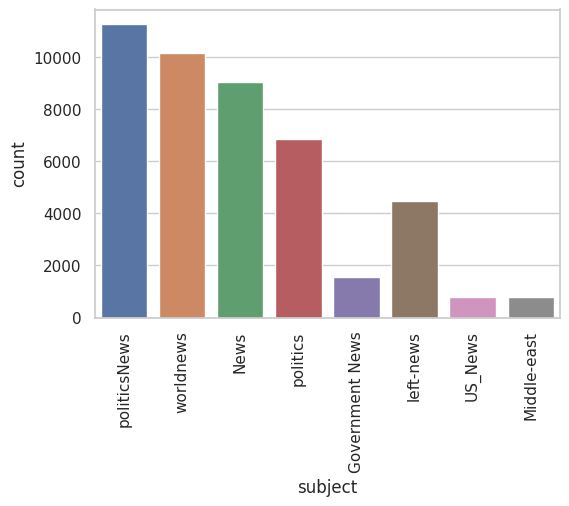

In [7]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

--------------------------------------------------------------

<font size="4">**Data preprocessing**</font>

In [8]:
data['text'] = data['title'] +' '+data['text']
del data['title']
del data['subject']
del data['date']

In [9]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [10]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [11]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [12]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,Right-Wing Pastor Calls Upon Christians To Di...,0
1,Hillary’s New Ad Brilliantly Uses Those Who H...,0
2,BREAKING: WHY IS OBAMA Sending Huge Number Of ...,0
3,Turkish nationalist opposition seeks to secure...,1
4,Clinton leads Trump by 2 points in Fox News po...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

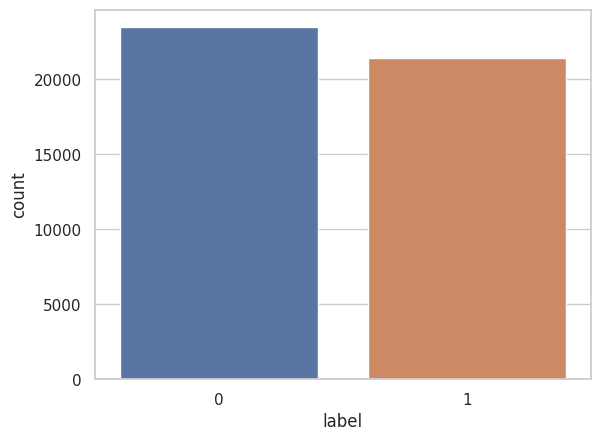

In [13]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

--------------------------------------------------------------

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [14]:
def preprocess_text(text):
    # TODO: create a function to clean your data
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

data['text'] = data['text'].apply(preprocess_text)

<font size="4">**Converting text into Vectors**</font>

In [15]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the preprocessed text data
X = vectorizer.fit_transform(data['text'])

# Print the shape of the vectorized data
print("Shape of vectorized data:", X.shape)



Shape of vectorized data: (44898, 219110)


-------------------------------------------------------------

<font size="4">**Model training, Evaluation, and Prediction**</font>

In [16]:
#TODO: Model training and print the accuracy score 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.987750556792873


In [17]:
# Display the Confusion matrix of Results from your classification algorithm
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[4645   56]
 [  54 4225]]


**Accuracy**: The accuracy of our model is 0.9877, indicating that it correctly classifies approximately 98.77% of the instances in the test set.

**Confusion Matrix**: The confusion matrix provides a breakdown of the predicted labels compared to the actual labels.
Here's the interpretation of the confusion matrix:

True Positives (4645): The number of instances correctly classified as "True" news.

True Negatives (4225): The number of instances correctly classified as "Fake" news.

False Positives (56): The number of instances wrongly classified as "True" news (actually "Fake" news).

False Negatives (54): The number of instances wrongly classified as "Fake" news (actually "True" news).

Overall, our model performs well with a high accuracy score of 0.9877

---------------------------------------------------------------

# Cross Validation

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [19]:

# Shuffle the data
data = shuffle(data)

# Reduce the dataset size for faster cross-validation
subset_data = data.sample(frac=0.1, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the preprocessed text data
X = vectorizer.fit_transform(subset_data['text'])
y = subset_data['label']

# Initialize the Random Forest model
model = RandomForestClassifier()

# Perform cross-validation on the smaller subset of data
cv_scores = cross_val_score(model, X, y, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Scores: [0.98106904 0.9766147  0.97550111 0.98329621 0.97995546]
Mean Accuracy: 0.9792873051224944


It seems that our random forest model is performing consistently well across different folds, with high cross-validation scores ranging from approximately 0.979 to 0.981. The mean cross-validation score of 0.979 indicates that the model is achieving a high level of accuracy on average.

Overall, these results suggest that our random forest model is performing well and generalizing effectively to unseen data, based on the cross-validation evaluation.

--------------------------------------------------------------------

# Grid Search for Hyperparameter Tuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle


In [23]:

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Reduce the dataset size for faster grid search
subset_X_train = X_train[:10000]
subset_y_train = y_train[:10000]

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5]
}

# Initialize the Random Forest model
model = RandomForestClassifier()

# Perform grid search with simplified hyperparameter values and reduced dataset
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(subset_X_train, subset_y_train)

# Print the best parameters found during grid search
print("Best parameters:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.9763996795600377
Accuracy: 0.9824053452115813


**Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}**
The best combination of hyperparameters found by the grid search is a **max_depth** of **None**, indicating that there is no limit on the depth of each tree in the random forest. The **min_samples_split** is set to 5, meaning that a node will be split if it contains at least 5 samples. The number of estimators (trees) in the random forest is set to 200.

**Best cross-validation score: 0.9763996795600377**
The cross-validation score is a measure of how well the model performs on unseen data. It is an average of the performance across different folds of the cross-validation. In this case, the best model achieved a cross-validation score of 0.9764, indicating a high level of accuracy on unseen data.

**Accuracy: 0.9824053452115813**
The accuracy of the model on the test set is 0.9824, meaning that approximately 98.24% of the instances in the test set were correctly classified by the model.

---------------------------------------------------------------------

# Evaluating our model's performance using other metrics

In [24]:
from sklearn.metrics import classification_report

In [25]:

# Calculate precision, recall, and F1 score
report = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4701
           1       0.98      0.98      0.98      4279

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



**Precision**: Precision is the proportion of correctly predicted positive instances out of all instances predicted as positive. For class 0 (fake news), the precision is 0.99, indicating that 99% of the predicted fake news instances were correct. For class 1 (true news), the precision is 0.98, meaning that 98% of the predicted true news instances were correct.

**Recall**: Recall, also known as sensitivity, is the proportion of correctly predicted positive instances out of all actual positive instances. For class 0, the recall is 0.98, indicating that the model identified 98% of the actual fake news instances. For class 1, the recall is also 0.98, meaning that the model correctly identified 98% of the actual true news instances.

**F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance. The F1-score for class 0 is 0.98, indicating a good balance between precision and recall for predicting fake news. The F1-score for class 1 is also 0.98, indicating a balanced performance for predicting true news.

**Support**: Support refers to the number of instances in each class. For class 0 (fake news), there are 4701 instances, and for class 1 (true news), there are 4279 instances.

**Accuracy**: The accuracy of the model is the proportion of correctly predicted instances out of all instances. In this case, the overall accuracy is 0.98, meaning that the model correctly classified approximately 98% of the instances in the test set.

The macro avg and weighted avg values provide average metrics across all classes. In this case, both macro avg and weighted avg are 0.98, indicating a balanced performance across the classes.

Overall, the classification report shows that the model achieved high precision, recall, and F1-scores for both classes, indicating its effectiveness in classifying news articles as either fake or true.

--------------------------------------------------------------

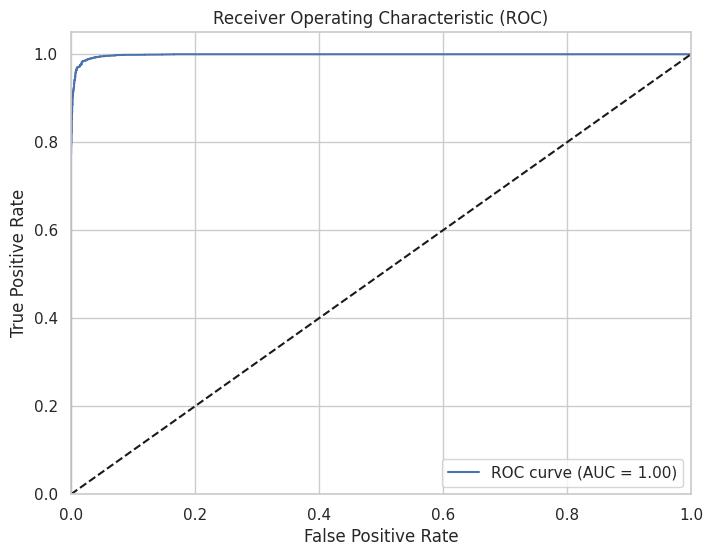

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


**model.decision_function(X_test)** calculates the decision function or predicted probabilities for the positive class. **roc_curve** computes the false positive rate (FPR), true positive rate (TPR), and corresponding thresholds. **auc** calculates the area under the ROC curve (AUC) using the FPR and TPR values.

The ROC curve is plotted using **plt.plot**, with the FPR on the x-axis and TPR on the y-axis. The AUC is displayed in the plot's legend. The plt.xlim, plt.ylim, plt.xlabel, plt.ylabel, and plt.title functions are used to set the plot's limits and labels.



-----------------------------------------------------------------------------------------------------------------------------